In [1]:
#Importing Keras packages
from __future__ import print_function
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras import optimizers
from tensorflow.keras.preprocessing import image
from keras.layers.advanced_activations import ELU, LeakyReLU, PReLU, Softmax, ReLU
from keras.regularizers import l2
from tensorflow.keras import initializers
import pandas as pd
import numpy as np

Using TensorFlow backend.


(50000, 1)
(10000, 1)
(50000, 32, 32, 3)
(10000, 32, 32, 3)


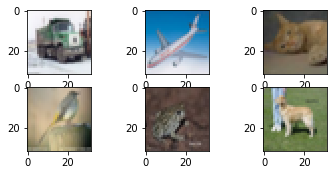

(50000, 32, 32, 3)
(10000, 32, 32, 3)
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [2]:
#Loading the CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(y_train.shape)
print(y_test.shape)
print(x_train.shape)
print(x_test.shape)

#Data Pre-processing and Inspection
img_rows = x_train[0].shape[0]
img_cols = x_train[1].shape[0]

#Inspection
import matplotlib.pyplot as plt

#Plotting 6 images with color map set to grey since the images are greyscale
plt.subplot(331)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(332)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(333)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(334)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(335)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(336)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))
plt.show()

#Normalise the data by changing the range from (0 to 255) to (0 to 1)
x_train =  x_train/255
x_test = x_test/255
print(x_train.shape)
print(x_test.shape)

#Change the image type to float32 data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [3]:
from tensorflow.keras.utils import to_categorical

#One-hot encode the outputs
y_cat_train = to_categorical(y_train,10)
y_cat_test = to_categorical(y_test,10)

print("Number of Classes: " + str(y_test.shape[1]))

num_classes = y_test.shape[1]
num_pixels = x_train.shape[1] * x_train.shape[2]
print("Number of Pixels: " + str(num_pixels)) #32*32=1024

y_train.shape
y_train[0]

Number of Classes: 1
Number of Pixels: 1024


array([6], dtype=uint8)

In [4]:
#Setting up some of the hyperparameters
batch_size = 64
num_classes = 10
epochs = 10
input_shape = x_train.shape[1:]

In [5]:
#Ensuring the model is built on the existing GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
physical_devices------------- 1


In [6]:
#Initiating ShallowNet for training
model = Sequential()

#1st Layer
model.add(Conv2D(128, (3, 3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#2nd Layer
model.add(Conv2D(128, (3, 3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#Pooling with Dropout
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.25))

#3rd Layer
model.add(Conv2D(256, (3, 3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#4th Layer
model.add(Conv2D(256, (3, 3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#Pooling with Dropout
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.25))

#5th Layer = 1st Fully Connected or Dense Layer
model.add(Flatten())
model.add(Dense(512, activation = 'elu', kernel_regularizer = l2(0.0005), kernel_initializer = "he_normal"))
model.add(BatchNormalization())
model.add(Dropout(0.35))

#6th Layer = Final Layer
model.add(Dense(10, kernel_regularizer = l2(0.0005), kernel_initializer = "he_normal"))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)        

In [7]:
#Model testing and reporting
opt = keras.optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

history = model.fit(x_train, y_cat_train, batch_size = batch_size, 
                    epochs = epochs, validation_data = (x_test, y_cat_test), shuffle = True)

#Saving model weights
model.save("C:\\Users\\Admin\\Desktop\\Research\\Results\\ShallowNet Results\\Weights\\CIFAR_ShallowNet_Weights_ELU_Adam.h5")

#Evaluate the performance of the trained model
scores = model.evaluate(x_test, y_cat_test, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 24s 478us/step - loss: 2.5994 - accuracy: 0.5199 - val_loss: 1.9646 - val_accuracy: 0.6584
Epoch 2/10
50000/50000 [==============================] - 21s 427us/step - loss: 1.7477 - accuracy: 0.6791 - val_loss: 1.6182 - val_accuracy: 0.6815
Epoch 3/10
50000/50000 [==============================] - 21s 427us/step - loss: 1.4078 - accuracy: 0.7264 - val_loss: 1.4810 - val_accuracy: 0.6897
Epoch 4/10
50000/50000 [==============================] - 22s 436us/step - loss: 1.2803 - accuracy: 0.7483 - val_loss: 1.3170 - val_accuracy: 0.7370
Epoch 5/10
50000/50000 [==============================] - 21s 430us/step - loss: 1.2430 - accuracy: 0.7650 - val_loss: 1.3356 - val_accuracy: 0.7284
Epoch 6/10
50000/50000 [==============================] - 22s 431us/step - loss: 1.2253 - accuracy: 0.7747 - val_loss: 1.3111 - val_accuracy: 0.7450
Epoch 7/10
50000/50000 [==============================] 

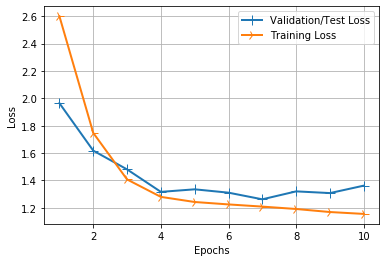

In [8]:
#Evaluating training and test error
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
#Classification report
model.metrics_names
print(model.metrics_names)
print(model.evaluate(x_test,y_cat_test,verbose = 0))

from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict_classes(x_test)

['loss', 'accuracy']
[1.3624050931930543, 0.7271000146865845]


In [10]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.63      0.74      1000
           1       0.92      0.81      0.86      1000
           2       0.71      0.66      0.69      1000
           3       0.43      0.74      0.54      1000
           4       0.84      0.59      0.69      1000
           5       0.52      0.78      0.62      1000
           6       0.83      0.81      0.82      1000
           7       0.92      0.59      0.72      1000
           8       0.93      0.79      0.85      1000
           9       0.81      0.87      0.84      1000

    accuracy                           0.73     10000
   macro avg       0.78      0.73      0.74     10000
weighted avg       0.78      0.73      0.74     10000



In [ ]:
#Testing model predictions
import cv2
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
classifier = load_model('C:\\Users\\Admin\\Desktop\\Research\\Results\\ShallowNet Results\\Weights\\CIFAR_ShallowNet_Weights_ELU_Adam.h5')
color = True 
scale = 8

def draw_test(name, res, input_im, scale, img_row, img_height):
    BLACK = [0,0,0]
    res = int(res)
    if res == 0:
        pred = "airplane"
    if res == 1:
        pred = "automobile"
    if res == 2:
        pred = "bird"
    if res == 3:
        pred = "cat"
    if res == 4:
        pred = "deer"
    if res == 5:
        pred = "dog"
    if res == 6:
        pred = "frog"
    if res == 7:
        pred = "horse"
    if res == 8:
        pred = "ship"
    if res == 9:
        pred = "truck"
        
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0]*2 ,cv2.BORDER_CONSTANT,value = BLACK)
    if color == False:
        expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, str(pred), (300, 80) , cv2.FONT_HERSHEY_COMPLEX_SMALL,4, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


for i in range(0,10):
    rand = np.random.randint(0,len(x_test))
    input_im = x_test[rand]
    imageL = cv2.resize(input_im, None, fx = scale, fy = scale, interpolation = cv2.INTER_CUBIC) 
    input_im = input_im.reshape(1,img_row, img_height, img_depth) 
    
    ## Get Prediction
    res = str(classifier.predict_classes(input_im, 1, verbose = 0)[0])
              
    draw_test("Prediction", res, imageL, scale, img_row, img_height) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

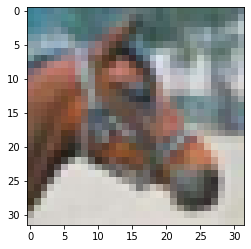

In [11]:
import matplotlib.pyplot as plt
my_image = x_test[17]
plt.imshow(my_image) #5 = Dog, #7 = Horse

In [12]:
model.predict_classes(my_image.reshape(1,32,32,3))

array([5], dtype=int64)

In [13]:
#Label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

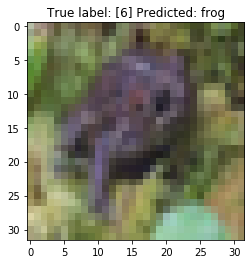

In [14]:
p_test = model.predict(x_test).argmax(axis=1)
y_test.flatten()
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], labels[p_test[i]]));